In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
%matplotlib inline

In [65]:
name = 'E1_Rforestales'
df = gpd.read_file('../data/interim/shapes/FBio_' + name + '.shp')
df = df[df.geometry.notnull()].to_crs({'init': 'epsg:4326'}) 
print (len(df))

313


In [66]:
df.columns

Index(['OBJECTID', 'EJERCICIO', 'ESTADO', 'TENENCIA', 'PREDIO', 'MUNICIPIO',
       'SUP_AUT', 'VOL_AUT', 'UNIDAD', 'PRODUCTO', 'ESP', 'ID', 'PREDIO_1',
       'TENENCIA_1', 'ENERGIA', 'CVE', 'ENERGIA_1', 'CLASIFICAC', 'INDUSTRIA',
       'TIPO', 'FUENTE', 'PROCESO', 'SUP_AUT_1', 'VOL_AU_M3', 'BIOMASA_TA',
       'POTEN_Tja', 'CAPINST_MW', 'FP', 'GENE_GWha', 'EMISION_Mt',
       'CAPINST_kW', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [61]:
df.head()

,ID,ESTADO,MUNICIPIO,LONGITUD,LATITUD,ENERGIA,CLASIFICAC,INDUSTRIA,TIPO,PROCESO,FUENTE,POTEN_Tja,CAPINST_MW,FP,GENE_GWha,EMISION_Mt,CAPINST_kW,geometry
index_left,,,,,,,,,,,,,,,,,,
0,25537.0,SONORA,HERMOSILLO,-110.954167,29.098889,BIOMASA,,GRANJAS PORCINAS,ESTIÉRCOL PORCINO,DIGESTIÓN ANAEROBIA,SEMARNAT - FIRCO,428.914932,6.128967,0.8,42.981217,21.486310,6128.966635,POINT (-110.954167 29.098889)
1,21099.0,DURANGO,GÓMEZ PALACIO,-103.465833,25.678333,BIOMASA,,ESTABLOS LECHEROS,ESTIÉRCOL BOVINO,DIGESTIÓN ANAEROBIA,SEMARNAT - FIRCO,283.131622,4.045801,0.8,28.372390,14.183358,4045.800544,POINT (-103.465833 25.678333)
2,25176.0,JALISCO,SAN JUAN DE LOS LAGOS,-102.332778,21.247778,BIOMASA,,GRANJAS PORCINAS,ESTIÉRCOL PORCINO,DIGESTIÓN ANAEROBIA,SEMARNAT - FIRCO,255.860064,3.656104,0.8,25.639529,12.817201,3656.104459,POINT (-102.332778 21.247778)
3,25667.0,TAMAULIPAS,SAN FERNANDO,-98.174936,25.102492,BIOMASA,,GRANJAS PORCINAS,ESTIÉRCOL PORCINO,DIGESTIÓN ANAEROBIA,SEMARNAT - FIRCO,246.250260,3.518785,0.8,24.676539,12.335802,3518.785458,POINT (-98.174936 25.10249200000001)
4,25459.0,SONORA,CAJEME,-109.935000,27.489167,BIOMASA,,GRANJAS PORCINAS,ESTIÉRCOL PORCINO,DIGESTIÓN ANAEROBIA,SEMARNAT - FIRCO,128.573966,1.837254,0.8,12.884293,6.440858,1837.253703,POINT (-109.935 27.489167)


In [50]:
states = gpd.read_file('../data/interim/shapes/mex-states.shp')
# Reproject the file
states = states.to_crs({'init': 'epsg:4326'}) 

In [51]:
import json, os
with open(os.path.join('../data/interim/', 'trans-regions.json'), 'r') as fp:
    trans_regions = json.load(fp)

In [52]:
loadzones = gpd.read_file('../data/interim/shapes/Mask_T.shp')
loadzones = loadzones.to_crs({'init': 'epsg:4326'}) 
loadzones['trans-region'] = loadzones['ID'].astype(int).map('{0:02}'.format).map(trans_regions)

In [53]:
assert loadzones.crs == df.crs

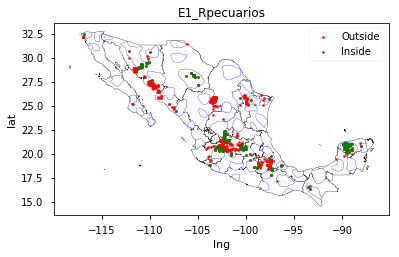

In [54]:
# Base plot
base = states.plot(color='white', edgecolor='black')
loadzones.plot(ax=base, color='white', edgecolor='blue', label='Loadzones')
df.plot(color='red', ax=base, label='Outside', markersize=5)
if not 'forestales' in name:
    join = gpd.sjoin(df, loadzones, op='within')
    join.plot(ax=base, color='green', label='Inside', markersize=5)
else:
    join = gpd.overlay(loadzones, df, how='intersection')
    join.plot(ax=base, color='green', legend=True)
plt.title(name)
plt.xlabel('lng')
plt.ylabel('lat')
plt.legend();
#plt.savefig(name + '.png', dpi=300)

In [58]:
# Create data
os.makedirs('data', exist_ok=True)
try: 
    columns = ['trans-region', 'X', 'Y', 'CLASIFICAC', 'TIPO', 'PROCESO', 
               'GENE_GWha', 'CAPINST_MW', 'FP',]
    bioenergy = join[columns].copy();
except KeyError:
    columns = ['LATITUD', 'LONGITUD', 'trans-region', 'CLASIFICAC', 'TIPO', 'PROCESO', 
               'GENE_GWha', 'CAPINST_MW', 'FP']
    bioenergy = join[columns].copy();
bioenergy['CLASIFICAC'] = bioenergy.CLASIFICAC.map(str.lower).str.replace(' ', '_')
bioenergy['TIPO'] = bioenergy.TIPO.map(str.lower).str.replace(' ', '_')
bioenergy['PROCESO'] = bioenergy.PROCESO.map(str.lower).str.replace(' ', '_')
if 'E3' in name:
    scenario = 'high'
else:
    scenario = 'low'
bioenergy.loc[:, 'scenario'] = scenario
bioenergy = bioenergy.rename(columns={'X': 'lng','LATITUD':'lat', 'LONGITUD': 'lng', 'Y': 'lat', 'CLASIFICAC': 'source',
                         'TIPO': 'category', 'FP': 'cf',
                         'GENE_GWha': 'gen_GWha', 'CAPINST_MW':'cap_MW',
                         'PROCESO': 'fuel_type'})

In [59]:
bioenergy.to_csv('data/{}.csv'.format(name), index=False)

In [ ]:
from itertools import zip_longest

#join = gpd.sjoin(df, loadzones, op='within')
load_zones_out = loadzones[~loadzones['trans-region']
                          .isin(join['trans-region'].unique())]['trans-region']
load_zones_in = join.groupby('trans-region')['geometry'].count().index.values
#join = gpd.overlay(loadzones, df, how='intersection')
with open(name + '.txt', 'w') as fpd:
    fpd.write('Trans regions included:\t{0}\n'.format(len(join['trans-region'].unique())))
    fpd.write('Trans regions not included: \t{0}\n'
              .format(len(loadzones[~loadzones['trans-region']
                                    .isin(join['trans-region'].unique())])))
    fpd.write('Total points:\t{0}\n'.format(len(df)))
    fpd.write('Points inside:\t{0}\n'.format(len(join)))
    fpd.write('Points outside:\t{0}\n'.format(len(df) - len(join)))
    fpd.write('Trans_in\tTrans_out\n')
    for values in zip_longest(*[load_zones_in, load_zones_out]):
        fpd.write('{0}\t{1}\n'.format(values[0],values[1]))

In [3]:
df1 = gpd.read_file('../data/interim/shapes/FBio_E3_Rforestales.shp')
df1 = df[df.geometry.notnull()].to_crs({'init': 'epsg:4326'}) 
df1['type'] = 'Rforestales'
df2 = gpd.read_file('../data/interim/shapes/FBio_E3_Rurbanos.shp')
df2 = df2.to_crs({'init': 'epsg:4326'}) 
df2['type'] = 'Rurbanos'
df3 = gpd.read_file('../data/interim/shapes/FBio_E3_Rindustriales.shp')
df3 = df3.to_crs({'init': 'epsg:4326'}) 
df3['type'] = 'Rindustriales'

df4 = gpd.read_file('../data/interim/shapes/FBio_E3_Rpecuarios.shp')
df4 = df4.to_crs({'init': 'epsg:4326'}) 
df4['type'] = 'Rpecuarios'

NameError: name 'df' is not defined

In [ ]:
import pandas as pd

In [ ]:
geo_data = gpd.GeoDataFrame(pd.concat([df1, df2, df3, df4], ignore_index=True))

In [ ]:
no_1 = gpd.sjoin(geo_data, loadzones, op='within')

In [ ]:
grouped = no_1.groupby(['trans-region', 'type'])['ID_right'].count()

In [ ]:
grouped.unstack(1).dropna()

In [ ]:
gpd.sjoin(df3, no_1, op='within')

In [ ]:
no_1